# Predict Insurance Cost with Linear Regression

First we will need to install some libraries and import the appropriate libraries

In [1]:
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: | 
  - anaconda/osx-64::conda-4.8.3-py37_0, anaconda/osx-64::openssl-1.1.1d-h1de35cc_2
  - anaconda/osx-64::openssl-1.1.1d-h1de35cc_2, defaults/osx-64::conda-4.8.3-py37_0
  - anaconda/osx-64::conda-4.8.3-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35cc_2
  - defaults/osx-64::conda-4.8.3-py37_0, defaults/osx-64::openssl-1.1.1d-h1de35ccdone

## Package Plan ##

  environment location: /Users/radhakatkamwar/opt/anaconda3

  added / updated specs:
    - cpuonly
    - numpy
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cpuonly-1.0                |                0           2 KB  pytorch
    ninja-1.9.0                |   py37h04f5b5a_0          90 KB
    pytorch-1.5.0              |          py3.7_0        34.7 MB  pytorch
    torchvision-0.6.0          |         py37_cpu         5.8 MB  pytorch
    ------------------------------------

In [1]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

# Downloading the datasets

In [2]:
url = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
filename = "insurance.csv"
download_url(url, '.')

Using downloaded and verified file: ./insurance.csv


In [3]:
dataframe = pd.read_csv(filename)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
num_rows = len(dataframe)
print(num_rows)

1338


In [5]:
numerical_cols = dataframe._get_numeric_data().columns
categorical_cols = set(dataframe.columns) - set(numerical_cols)
input_cols = list(dataframe.columns[:-1])
output_cols = dataframe.columns[-1:]

In [78]:
def dataframe_to_arrays(dataframe):
    dataframe1 = dataframe.copy(deep=True)
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [79]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[19.  ,  0.  , 27.9 ,  0.  ,  1.  ,  3.  ],
        [18.  ,  1.  , 33.77,  1.  ,  0.  ,  2.  ],
        [28.  ,  1.  , 33.  ,  3.  ,  0.  ,  2.  ],
        ...,
        [18.  ,  0.  , 36.85,  0.  ,  0.  ,  2.  ],
        [21.  ,  0.  , 25.8 ,  0.  ,  0.  ,  3.  ],
        [61.  ,  0.  , 29.07,  0.  ,  1.  ,  1.  ]]), array([[16884.924 ],
        [ 1725.5523],
        [ 4449.462 ],
        ...,
        [ 1629.8335],
        [ 2007.945 ],
        [29141.3603]]))

In [80]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)
inputs, targets

(tensor([[19.0000,  0.0000, 27.9000,  0.0000,  1.0000,  3.0000],
         [18.0000,  1.0000, 33.7700,  1.0000,  0.0000,  2.0000],
         [28.0000,  1.0000, 33.0000,  3.0000,  0.0000,  2.0000],
         ...,
         [18.0000,  0.0000, 36.8500,  0.0000,  0.0000,  2.0000],
         [21.0000,  0.0000, 25.8000,  0.0000,  0.0000,  3.0000],
         [61.0000,  0.0000, 29.0700,  0.0000,  1.0000,  1.0000]]),
 tensor([[16884.9238],
         [ 1725.5522],
         [ 4449.4619],
         ...,
         [ 1629.8335],
         [ 2007.9449],
         [29141.3594]]))

In [81]:
dataset = TensorDataset(inputs, targets)

# Data Analysis

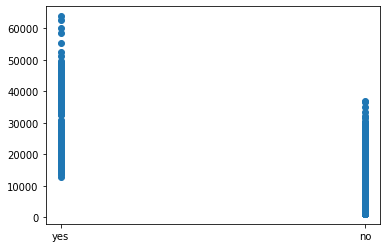

In [82]:
plt.scatter(dataframe['smoker'], dataframe['charges'])

Text(0, 0.5, 'charges')

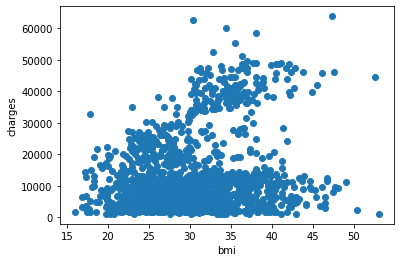

In [88]:
plt.scatter(dataframe['bmi'], dataframe['charges'])
plt.xlabel("bmi")
plt.ylabel("charges")

<BarContainer object of 1338 artists>

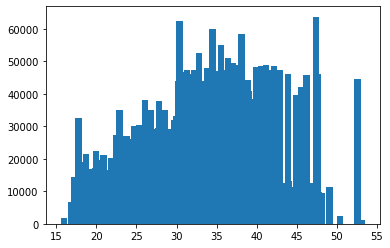

In [93]:
plt.bar(dataframe['bmi'], dataframe['charges'])

# Choosing a value for validation set

In [46]:
val_percent = 0.17 # This will be the percentage of the data that will be used for the validation set
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = torch.utils.data.random_split(dataset,[train_size,val_size])

# Batch size

In [47]:
batch_size = 16

In [48]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# Linear Regressions model

In [49]:
input_size = len(input_cols)
output_size = len(output_cols)

In [50]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  
        
    def forward(self, xb):
        out = self.linear(xb)                          
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)          
        loss = F.l1_loss(out, targets)                       
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.l1_loss(out, targets)                               
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [51]:
model = InsuranceModel()

In [84]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [85]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 6187.50244140625}


# Epochs training

In [54]:
epochs = 100
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6740.3760
Epoch [40], val_loss: 6552.0205
Epoch [60], val_loss: 6395.3901
Epoch [80], val_loss: 6284.5483
Epoch [100], val_loss: 6219.6709


In [55]:
epochs = 200
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6216.9507
Epoch [40], val_loss: 6213.4995
Epoch [60], val_loss: 6210.5547
Epoch [80], val_loss: 6208.0850
Epoch [100], val_loss: 6204.9990
Epoch [120], val_loss: 6202.4941
Epoch [140], val_loss: 6200.2290
Epoch [160], val_loss: 6196.8896
Epoch [180], val_loss: 6194.2500
Epoch [200], val_loss: 6191.5156


In [56]:
epochs = 300
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6191.1997
Epoch [40], val_loss: 6190.8823
Epoch [60], val_loss: 6190.6270
Epoch [80], val_loss: 6190.3804
Epoch [100], val_loss: 6190.0962
Epoch [120], val_loss: 6189.8506
Epoch [140], val_loss: 6189.5884
Epoch [160], val_loss: 6189.3618
Epoch [180], val_loss: 6189.1357
Epoch [200], val_loss: 6188.9111
Epoch [220], val_loss: 6188.7012
Epoch [240], val_loss: 6188.4741
Epoch [260], val_loss: 6188.2944
Epoch [280], val_loss: 6188.1182
Epoch [300], val_loss: 6187.9170


In [57]:
epochs = 400
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6187.8970
Epoch [40], val_loss: 6187.8813
Epoch [60], val_loss: 6187.8599
Epoch [80], val_loss: 6187.8418
Epoch [100], val_loss: 6187.8247
Epoch [120], val_loss: 6187.8066
Epoch [140], val_loss: 6187.7876
Epoch [160], val_loss: 6187.7681
Epoch [180], val_loss: 6187.7495
Epoch [200], val_loss: 6187.7275
Epoch [220], val_loss: 6187.7119
Epoch [240], val_loss: 6187.6924
Epoch [260], val_loss: 6187.6743
Epoch [280], val_loss: 6187.6558
Epoch [300], val_loss: 6187.6377
Epoch [320], val_loss: 6187.6177
Epoch [340], val_loss: 6187.5996
Epoch [360], val_loss: 6187.5830
Epoch [380], val_loss: 6187.5630
Epoch [400], val_loss: 6187.5439


In [58]:
epochs = 500
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6187.5410
Epoch [40], val_loss: 6187.5400
Epoch [60], val_loss: 6187.5381
Epoch [80], val_loss: 6187.5381
Epoch [100], val_loss: 6187.5361
Epoch [120], val_loss: 6187.5337
Epoch [140], val_loss: 6187.5312
Epoch [160], val_loss: 6187.5308
Epoch [180], val_loss: 6187.5298
Epoch [200], val_loss: 6187.5269
Epoch [220], val_loss: 6187.5254
Epoch [240], val_loss: 6187.5239
Epoch [260], val_loss: 6187.5229
Epoch [280], val_loss: 6187.5205
Epoch [300], val_loss: 6187.5200
Epoch [320], val_loss: 6187.5171
Epoch [340], val_loss: 6187.5161
Epoch [360], val_loss: 6187.5146
Epoch [380], val_loss: 6187.5132
Epoch [400], val_loss: 6187.5107
Epoch [420], val_loss: 6187.5103
Epoch [440], val_loss: 6187.5073
Epoch [460], val_loss: 6187.5063
Epoch [480], val_loss: 6187.5044
Epoch [500], val_loss: 6187.5024


# Calculating the final loss 

In [59]:
val_loss = history5[-1]
val_loss

{'val_loss': 6187.50244140625}

# Making predictions

In [64]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)               
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [65]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([21.0000,  0.0000, 34.6000,  0.0000,  0.0000,  3.0000])
Target: tensor([2020.1770])
Prediction: tensor([2731.2839])


In [62]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([61.0000,  1.0000, 43.4000,  0.0000,  0.0000,  3.0000])
Target: tensor([12574.0488])
Prediction: tensor([11986.3564])


In [63]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([38.0000,  0.0000, 27.8350,  2.0000,  0.0000,  0.0000])
Target: tensor([7144.8628])
Prediction: tensor([7465.0493])


*Credits to Aakash N S 